O processo de preparar dados para análise é chamado de "data wrangling" e geralmente ocupa a maior parte do tempo de um analista em um projeto de dados. Alguns dos problemas comuns incluem:

- Dados ausentes ou valores incorretos/problemas no conjunto de dados;
- Dados formatados de maneira inadequada, impedindo o trabalho adequado do analista;
- Dados distribuídos em vários arquivos ou tabelas;
- Dados no formato incorreto para análise e visualização.

Você está aprendendo a trabalhar com o pandas porque ele pode lidar com todas essas tarefas de forma flexível. Neste notebook, abordaremos exemplos básicos de como isso funciona, que você aplicará nos exercícios ao final. O dataset utilizado será o College Scorecard, do Departamento de Educação dos EUA.

In [4]:
import pandas as pd

url = 'http://personal.tcu.edu/kylewalker/data/colleges.csv'
data = pd.read_csv(url, encoding = 'latin_1')
data.shape

(7804, 122)

Observamos que nosso conjunto de dados possui mais de 7800 linhas e 122 colunas! Neste ponto, embora você ainda não saiba quais insights estão contidos nos dados, já deve ter uma ideia das perguntas de pesquisa que lhe interessam. Como essas perguntas provavelmente não exigem todas as 122 colunas, é seguro restringir o conjunto de dados apenas às colunas necessárias para sua análise. Nossa principal pergunta de pesquisa é:

**Como a proporção de estudantes alunos de graduação com 25 anos ou mais varia entre faculdades e universidades que possuem bacharelado?**

Para responder a essa pergunta, precisamos identificar algumas colunas essenciais e filtrar os dados de acordo. As colunas que manteremos são as seguintes:

- **INSTNM**: Nome da instituição;
- **STABBR**: Estado onde a instituição está localizada;
- **PREDDEG**: Tipo principal de diploma concedido pela instituição (códigos: 1 para certificados, 2 para diplomas de associado, 3 para bacharelados e 4 para pós-graduação);
- **CONTROL**: Propriedade da instituição (códigos: 1 para pública sem fins lucrativos, 2 para privada sem fins lucrativos, e 3 para privada com fins lucrativos);
- **UGDS**: Número de alunos de graduação matriculados na instituição;
- **UG25abv**: Percentual de alunos de graduação com 25 anos ou mais na instituição.


In [5]:
cols = ['INSTNM', 'STABBR', 'PREDDEG', 'CONTROL', 'UGDS', 'UG25abv']
df = data.filter(cols)

Existem, pequenas coisas que você pode fazer no DataFrame diretamente para facilitar o trabalho. Por exemplo, não quero ter que ativar o Caps Lock ou pressionar Shift toda vez que digitar nomes de colunas, mas os nomes das colunas no meu DataFrame estão em maiúsculas. Como os nomes das colunas são simplesmente uma lista de strings, podemos usar métodos de string para manipulá-las. Podemos, por exemplo, usar compreensão de lista para converter todos os nomes de colunas em minúsculas:

In [7]:
df.columns = [col.lower() for col in df.columns]
df.head()

,instnm,stabbr,preddeg,control,ugds,ug25abv
0,Alabama A & M University,AL,3,1,4051.0,0.1049
1,University of Alabama at Birmingham,AL,3,1,11200.0,0.2422
2,Amridge University,AL,3,2,322.0,0.8540
3,University of Alabama in Huntsville,AL,3,1,5525.0,0.2640
4,Alabama State University,AL,3,1,5354.0,0.1270


Também podemos modificar os nomes das colunas do DataFrame individualmente ou passando uma lista de novos nomes. Por exemplo, "state" faz mais sentido do que "stabbr" e "institution" é mais claro do que "instnm". O código abaixo realiza essas mudanças:

In [8]:
df.rename(columns={'stabbr': 'state', 'instnm': 'institution'}, inplace=True)
df.head()

O método rename usa um dicionário para fazer as alterações nas colunas. Como é uma mudança menor, utilizamos inplace=True para modificar o DataFrame diretamente.

Agora, queremos filtrar os dados para universidades que concedem bacharelado (código 3 na coluna preddeg). Primeiro, verificamos o tipo de dado dessa coluna com:

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7804 entries, 0 to 7803
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   institution  7804 non-null   object 
 1   state        7804 non-null   object 
 2   preddeg      7804 non-null   int64  
 3   control      7804 non-null   int64  
 4   ugds         7090 non-null   float64
 5   ug25abv      7031 non-null   float64
dtypes: float64(2), int64(2), object(2)
memory usage: 365.9+ KB


A coluna `preddeg` parece ser um número inteiro, então trabalharemos com seus valores como números. Nas aulas passadas usamos :

```python
new_df = df[df['preddeg']==3]

```

Para filtrar linhas no pandas, podemos usar o método `.query()`, que avalia uma expressão com operadores lógicos/booleanos. O método retorna as linhas onde a expressão é verdadeira e descarta as demais. Neste caso, queremos as linhas onde `preddeg` é igual a 3. Vamos criar um novo DataFrame chamado `new_df` com essa expressão:

In [28]:
newDf = df.query('preddeg == 3')
len(newDf)

2133

No pandas, dados ausentes podem ser representados como NaN (do NumPy) ou None (do Python). Para detectar esses valores, podemos usar os métodos .isnull() ou .isna(). Vamos consultar nosso DataFrame de graduação (new_df) para verificar quantas linhas possuem valores ausentes na coluna ug25abv. Podemos usar o argumento engine='python' para executar o método dentro da expressão:

In [29]:
newDf_null = newDf.query('ug25abv.isnull()', engine='python')
newDf_null.shape

(36, 6)

E os valores não nulos:

In [30]:
df_nonull = newDf.query('ug25abv.notna()')
df_nonull.shape

(2097, 6)

Uma abodagem muito importante em análise de dadoos é a "split-apply-combine", que envolve:

1. Dividir os dados em grupos com base em uma característica comum;
2. Aplicar uma função a cada grupo;
3. Combinar os resultados para permitir comparações entre grupos.

Essa abordagem é muito poderosa e comum na análise de dados. Vamos usar essa técnica para responder às seguintes perguntas:

- Como a proporção de estudantes de graduação acima de 25 anos varia entre universidades públicas, privadas e com fins lucrativos?
- Como essa proporção varia conforme o tamanho da instituição?

A análise por grupo no pandas é feita criando um objeto `groupby`. Para a primeira pergunta, agruparemos os dados por tipo de instituição. O código abaixo faz isso:

In [37]:
group = df_nonull.groupby('control')
group

In [38]:
group['ug25abv'].mean()

control
1    0.215475
2    0.235799
3    0.670381
Name: ug25abv, dtype: float64

Muito interessante — enquanto universidades públicas e privadas sem fins lucrativos têm composições de idade semelhantes, com 21-23% de seus alunos acima de 25 anos, as universidades privadas com fins lucrativos são bem diferentes, com mais de dois terços dos alunos nessa faixa etária.

Vamos visualizar isso usando o Seaborn, que é ótimo para análises por grupo. Gráficos como box plots e violin plots podem ser usados para comparar grupos, bastando especificar uma segunda coluna para o gráfico.

Exemplo de como fazer isso:

<Axes: xlabel='control', ylabel='ug25abv'>

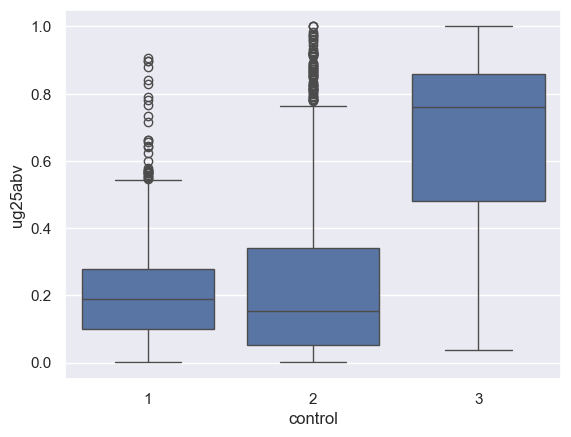

In [42]:
import seaborn as sns

sns.set_theme(style = "darkgrid")

sns.boxplot(data = df_nonull, x = 'control', y = 'ug25abv')

Aqui podemos ver claramente as variações nas distribuições entre os grupos. Embora a média de estudantes acima de 25 anos nas instituições públicas sem fins lucrativos seja menor do que nas privadas sem fins lucrativos, parece que a mediana nas privadas sem fins lucrativos é ainda mais baixa, com uma cauda mais longa de instituições com uma grande proporção de alunos acima de 25 anos. Já nas privadas com fins lucrativos, a mediana está acima de 70%.